# HW4: Wage Growth During the Recession

Before you start this assignment, you'll have to install the `weightedstats` package. You can do this by running `pip install weightedstats` in a terminal. For more information, see here: https://pypi.org/project/weightedstats/ . We will use this package to compute a weighted median.


### Each question is marked Q1, Q2, etc. Each is worth 2 point.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import weightedstats
import seaborn as sns
import quandl
sns.set()

pd.options.display.max_columns = 25
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 100
pd.set_option('display.float_format', lambda x: '%.3f' % x)



In [2]:
# Change default figure size
plt.rcParams['figure.figsize'] = 6, 5

# 1. Introduction

Wages at the aggregate level have been found to rise during the recent recession (or at least not decline). This is surprising given that aggregate labor conditions were so weak. Many economists have viewed this as a puzzle. The goal in this question is to assess whether this is a puzzle, given that the composition of workers are changing over time. We begin by establishing the facts from which this puzzle arises. 

The great recession is generally defined as having lasted from December 2007 to June 2009. For example, see the corresponding article on Wikipedia: https://en.wikipedia.org/wiki/Great_Recession_in_the_United_States

> The Great Recession in the United States was a severe financial crisis combined with a deep recession. While the recession officially lasted from December 2007 to June 2009, it took several years for the economy to recover to pre-crisis levels of employment and output.


Consider the following graph. This graph plots the median weekly real earnings for wage and salary workers ages 16 years and older. The shaded areas in the plots denote officially defined periods of recession, as defined by NBER. Notice that wages during the period of the great recession appear to be increasing. In this document we will be investigating this fact.

![Median Real Earnings](./median_real_earnings_FRED.png)



### Q1. Retrieve and plot this data from FRED using Quandl

 - Find the data for the FRED plot shown above on Quandl. You can find it using Google and the title. You can also search directly in the FRED section of Quandl for the code in the top left corner below the star next to the title.
 - Also, find the data for the same figure, except restricted to "men". This is called "Employed full time: Median usual weekly real earnings: Wage and salary workers: 16 years and over: Men (LES1252881900Q)" To eliminate other potentially confounding factors, we will try to narrow the demographic group we are studying.
 - Make a simple plot of both of these data series using Pandas' built-in plot methods. Restrict the time period to show from 2000 to 2017.
 - No need to make the shaded recession bars in your plot. I'm just looking for the simplest, easiest plot possible. Just be sure it's labelled (e.q, use `plt.title('Median ...')`).

In [3]:
# Employed full time: Median usual weekly real earnings:
# Wage and salary workers: 16 years and over (FRED/LES1252881600Q)
# https://www.quandl.com/data/FRED/LES1252881600Q
intro_median = quandl.get('FRED/LES1252881600Q')

# Employed full time: Median usual weekly real earnings:
# Wage and salary workers: 16 years and over (FRED/LES1252881600Q),
# Men
# https://www.quandl.com/data/FRED/LES1252881900Q
intro_median_men = quandl.get('FRED/LES1252881900Q')

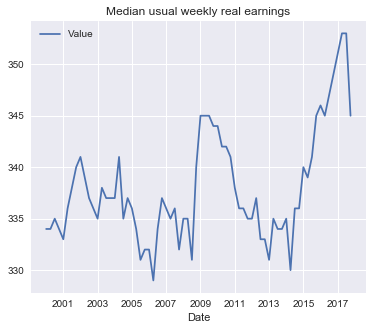

In [4]:
intro_median['2000':'2017'].plot()
plt.title('Median usual weekly real earnings');

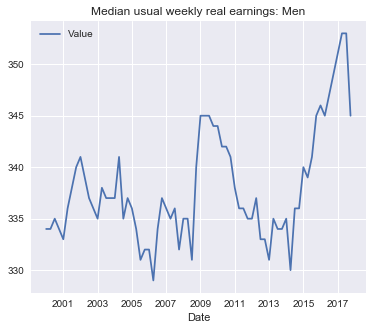

In [5]:
intro_median['2000':'2017'].plot()
plt.title('Median usual weekly real earnings: Men');

# 2. Demographic data from US Current Population Survey

To study this puzzling fact, we will analyze how changing demographics might affect our aggregate measures of wages. One of our biggest concerns is that as employment rates fell, they fell more for low educated workers than high educated workers. That means the average wages we are measuring will actually be comparing different types of workers in 2010 relative to 2006. This could potentially explain why wages are rising. We will attempt to compensate for this by constructing a demographically adjusted time series for wages. 

## Game Plan

Here is a summary of what we will do. I will give you more specific instructions afterwards to walk you through this.

Use data from the 2000-2017 March CPS (downloaded from IPUMS CPS web site) to examine the time series (annual) trend in both nominal and real wages for 25-54 year old men not living in group quarters.  (You need to download the group quarters variable).  Wages will be defined as annual earnings (last year) divided by annual hours (last year).  Annual hours can be computed by multiplying weeks worked last year by usual hours worked (last year). You should do this for a sample of all workers with a positive wage last year. Typically, you can convert to real wages using any deflator you wish. Here, I will require using the CPI99 variable to convert to 1999 dollars. (Note: Many economists like to use the June CPI-U. June is in the middle of the year and, for that reason, avoids some issues with seasonality. The choice of year doesn't matter.)


### Q2. Download and Read the CPS Data from IPUMS

When you download the data from IPUMS, *only download the data that you need*. This is important, because the data gets very big very fast when you start adding other variables. IPUMS will automatically add certain variables to your "cart". Go ahead and remove the ones that you don't need. This will make things much easier. The list of variables that you need are listed below. Make sure to stick to just those variables. I have provided the code to read in the data.

The data should contain the following variables:

1. YEAR (Survey year)
2. GQ (Group Quarters status)
3. CPI99 (CPI-U adjustment factor to 1999 dollars)
4. ASECWT (Annual Social and Economic Supplement Weight)
5. AGE (Age)
6. SEX (Sex)
7. LABFORCE (Labor force status)
8. EDUC (Educational attainment recode)
9. WKSWORK1 (Weeks worked last year)
10. HRSWORKLY (Usual hours worked per week (last yr))
11. INCWAGE (Wage and salary income)

In [6]:
## Read and Prepare the Data

# Change this to the name of your data file
PATH_TO_CPS_FILE = 'cps_00007.csv'

df = pd.read_csv(PATH_TO_CPS_FILE)
df['YEAR'] = pd.to_datetime(df.YEAR, format='%Y')

categorical_cols = ['GQ', 'SEX', 'EDUC', 'LABFORCE']
for col in categorical_cols:
    df[col] = df[col].astype('category')

# In case these variales were included in the dataset,
# Drop the variables that we will not need in this exercise.
labels = ['MONTH', 'ASECFLAG', 'EMPSTAT', 'FTOTVAL', 'PERNUM', 'SERIAL']
for label in labels:
    try:
        df.drop(labels=label, inplace=True, axis=1)
    except:
        pass

In [7]:
# Run this code to see how much memory your data set is using.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3627835 entries, 0 to 3627834
Data columns (total 11 columns):
YEAR          datetime64[ns]
GQ            category
CPI99         float64
ASECWT        float64
AGE           int64
SEX           category
LABFORCE      category
EDUC          category
WKSWORK1      int64
UHRSWORKLY    int64
INCWAGE       int64
dtypes: category(4), datetime64[ns](1), float64(2), int64(4)
memory usage: 207.6 MB


When filling in the missing values, keep in mind the codings for each variable. Consult the associated codebook and IPUMS documentation for complete information. (I've included the codebook from my data extract here: `cps_00007_codebook.pdf`) 

For your convenience, I've reproduced some information about some of our variables below. 

#### UHRSWORKLY

For UHRSWORKLY: Usual hours worked per week (last yr) https://cps.ipums.org/cps-action/variables/UHRSWORKLY#codes_section

    UHRSWORKLY is a 2-digit numeric value.

    99 = 99 hours or more 
    999 = NIU (Not in universe)
    
> WKSWORK1 reports the number of weeks, in single weeks, that the respondent worked for profit, pay, or as an unpaid family worker during the preceding calendar year. Respondents were prompted to count weeks in which they worked for even a few hours and to include paid vacation and sick leave as work. Information on weeks worked during the preceding year is available in the form of intervals for 1962 forward in the WKSWORK2 variable.

#### INCWAGE

For INCWAGE: Wage and salary income https://cps.ipums.org/cps-action/variables/INCWAGE#description_section

    Codes
    9999999 = N.I.U. (Not in Universe). 
    9999998 = Missing.
    
> INCWAGE indicates each respondent's total pre-tax wage and salary income--that is, money received as an employee--for the previous calendar year. Amounts are expressed as they were reported to the interviewer; users must adjust for inflation using Consumer Price Index adjustment factors.

> For ASEC samples 1988-onward, INCWAGE is derived from a Census recode variable. The topcoded components of INCWAGE are OINCWAGE and INCLONGJ. OINCWAGE is always a component of INCWAGE. When SRCEARN indicates that INCLONGJ is earned from wage and salary, INCLONGJ is an additional component of INCWAGE.
    
#### CPI99

For CPI99: CPI99 is a 4-digit variable with three implied decimal places. https://cps.ipums.org/cps-action/variables/CPI99#description_section

> CPI99 provides the CPI-U multiplier (available from the Bureau of Labor Statistics) to convert dollar figures to constant 1999 dollars. (This corresponds to the dollar amounts in the 2000 CPS, which inquired about income in 1999.) Multiplying dollar amounts by this variable (which is constant within years) will render them comparable across time and thus suitable for multivariate analysis.

> For more information on how to use CPI99, please see the IPUMS inflation adjustment page.
    
    
    0   NIU
    1   No, not in the labor force
    2   Yes, in the labor force


#### LABFORCE 

https://cps.ipums.org/cps-action/variables/LABFORCE#codes_section

    Codes:
    0   NIU
    1   No, not in the labor force
    2   Yes, in the labor force

> LABFORCE is a dichotomous variable indicating whether the respondent participated in the labor force during the preceding week. See EMPSTAT for a more detailed employment status variable. Those coded as "yes" in LABFORCE were either: were at work; held a job but were temporarily absent from work due to factors like vacation or illness; were seeking work; or were temporarily laid off from a job during the reference period.

> Because the CPS is designed to measure unemployment in the civilian population, the original dichotomous employment status variable in the survey classifies members of the armed forces as NIU (Not in universe).

### Q3. Recode the missing data

Each variable in the CPS data that we downloaded has specific codes used to represent missing data. There is also a difference between data that is missing and data that is considered "NIU", meaning "Not in Universe." Consult the documentation for the meaning of each of the codes for each of the variables. Convert all missing values and NIU values to `np.nan`.

For example, you should include the following code for INCWAGE:

```python
# INCWAGE: Missing values
# 9999999 = N.I.U. (Not in Universe). 
# 9999998 = Missing.
df.loc[df.INCWAGE == 9999999, 'INCWAGE'] = np.nan
df.loc[df.INCWAGE == 9999998, 'INCWAGE'] = np.nan
```

In [8]:
## Fill in Missing Values or NIU
    
# UHRSWORKLY: Recode missing values
df.loc[df.UHRSWORKLY == 999, 'UHRSWORKLY'] = np.nan

# INCWAGE: Missing values
# 9999999 = N.I.U. (Not in Universe). 
# 9999998 = Missing.
df.loc[df.INCWAGE == 9999999, 'INCWAGE'] = np.nan
df.loc[df.INCWAGE == 9999998, 'INCWAGE'] = np.nan

# Note that the code below will give the "SettingWithCopyWarning" warning.
# df.UHRSWORKLY[df.UHRSWORKLY == 999] = np.nan
# df.INCWAGE[df.INCWAGE == 9999999] = np.nan
# df.INCWAGE[df.INCWAGE == 9999998] = np.nan

# LABFORCE missing values
# 0 = NIU
df.loc[df.LABFORCE == 0, 'LABFORCE'] = np.nan

# EDUC Missing values
EDUC_missing_list = [999, 1, 0]
for educ_code in EDUC_missing_list:
    df.loc[df.EDUC == educ_code, 'EDUC'] = np.nan

# GQ Missing values
df.loc[df.GQ == 0, 'GQ'] = np.nan
    
# SEX Missing values
df.loc[df.SEX == 9, 'SEX'] = np.nan


# TODO: Alternative way is currently NOT WORKING
# missing_values = {
#     'UHRSWORKLY': {999: np.nan},
#     'INCWAGE': {9999998: np.nan, 9999999: np.nan},
#     'LABFORCE': {0: np.nan},
#     'EDUC': {0: np.nan, 1: np.nan, 999: np.nan}
# }
# df.replace(to_replace=missing_values, inplace=True)


### Q4. Select the desired subsample of the data

As we mentioned, we want to narrow the demographic group under consideration. Drop all observations from `df` that don't match the following conditions.

> Use data from the 2000-2017 March CPS for 25-54 year old men not living in group quarters. Only consider individuals with a strictly positive income from wages.

For example, your code might start like this:

```python
# GQ = 0 for vacant units, 1 for Households, 2 for group quarters
df = df[df.GQ == 1]
```

In [9]:
## Select desired subsample
# GQ = 0 for vacant units, 1 for Households, 2 for group quarters
df = df[df.GQ == 1]
#  df.SEX = 1 for male
df = df[df.SEX == 1]
df = df[(df.AGE >= 25) & (df.AGE <=54) ]
df = df[df.INCWAGE > 0]

### Q5. Construct new  variables

Now, construct new variables called `real_incwage`, `annual_hours`, `real_wage`, and `in_labor_force`.

 - `real_incwage` is the CPI99 deflator times annual earnings (last year)
 - `annual_hours` is the weeks worked last year times the usual hours worked per week (last year).
 - `real_wage` is the annual earnings (last year) divided by annual hours (last year). Be sure to set `real_wage` equal to zero whenever `annual_hours` is equal to zero. (I use the following code:
 ```python
# To prevent infinite wages
df.loc[df.annual_hours <= 0, 'real_wage'] = 0
 ```
 - `in_labor_force` is a boolean variable that is True if the individual was coded as "Yes, in the labor force." Use the `LABFORCE` variable for this.



In [10]:
## Construct New Variables

df['real_incwage'] = df['CPI99'] * df.INCWAGE
df['annual_hours'] = df.WKSWORK1 * df.UHRSWORKLY
df['real_wage'] = df.real_incwage / df.annual_hours
# To prevent infinite wages
df.loc[df.annual_hours <= 0, 'real_wage'] = 0

# Create
df['in_labor_force'] = df.LABFORCE == 2

df = df.dropna()

### Q6. Drop data that we no longer need.

 - Run the code below to drop data that we don't need.
 - Also, you should drop all rows that contain a missing value.
 
```python
# Drop the variables that don't need anymore.
# Your data might not have some of these variables. 
labels = ['GQ', 'SEX', 'LABFORCE', 'CPI99', 'INCTOT', 'UHRSWORKLY', 
          'WKSWORK1', ]
for label in labels:
    try:
        df.drop(labels=label, inplace=True, axis=1)
    except:
        pass   
```

In [11]:
# Drop the variables that don't need anymore.
labels = ['GQ', 'SEX', 'LABFORCE', 'CPI99', 'INCTOT','WKSWORK1', ]
for label in labels:
    try:
        df.drop(labels=label, inplace=True, axis=1)
    except:
        pass   

In [12]:
df = df.dropna()

### Q7. Generate summary statistics

Use `describe` to generate summary statistics for the following variables:
`AGE`, `INCWAGE`, `real_incwage`, `annual_hours`, `real_wage`. (For now, disregard the fact that we need to use the survey weights to compute these figures.) What do you notice about the top end of the distribution of `real_wage`?

In [13]:
# There seem to be some very large wages at the top end of `real_wage`
df.describe()

,ASECWT,AGE,UHRSWORKLY,INCWAGE,real_incwage,annual_hours,real_wage
count,605925.000,605925.000,605925.000,605925.000,605925.000,605925.000,605925.000
mean,1589.072,39.626,43.476,54974.741,44567.092,2148.705,21.570
std,1204.537,8.316,9.675,62040.209,49111.192,611.484,411.273
min,25.330,25.000,1.000,1.000,0.726,1.000,0.000
25%,775.480,33.000,40.000,25000.000,20702.000,2080.000,10.252
50%,1431.190,40.000,40.000,40000.000,33845.000,2080.000,15.584
75%,2027.800,47.000,48.000,65000.000,52920.000,2340.000,23.827
max,44423.830,54.000,99.000,1699999.000,1298799.236,5148.000,312342.282


In [14]:
df.query('real_wage > 300000')

,YEAR,ASECWT,AGE,EDUC,UHRSWORKLY,INCWAGE,real_incwage,annual_hours,real_wage,in_labor_force
1944649,2009-01-01,3381.190,48,73,1.000,403543.000,312342.282,1.000,312342.282,True


### Q8. Plot a histograph of the average weekly hours and the average annual hours worked.

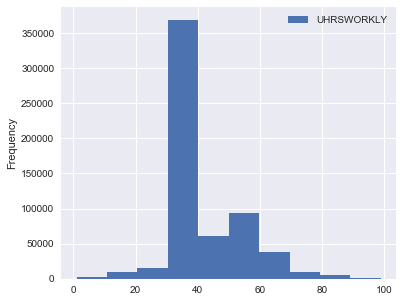

In [15]:
df[['UHRSWORKLY']].plot.hist()

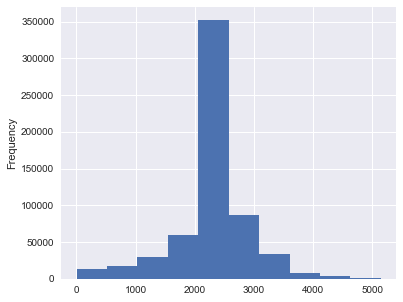

In [16]:
df.annual_hours.plot.hist()

### Q9. Plot a histogram of real wages.

 - Plot a histogram of `real_wage` using the default number of bins in pandas.
 - Plot a histogram of `real_wage` for only those with `real_wage` less than 200. Use the default number of bins.
 - Plot a histogram of `real_wage` for only those with `real_wage` less than 200. Use 50 bins.

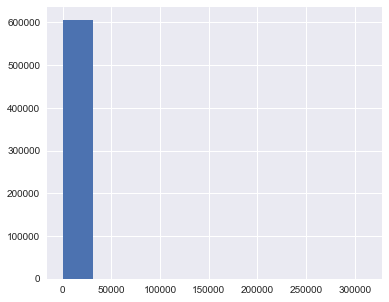

In [17]:
df.real_wage.hist()

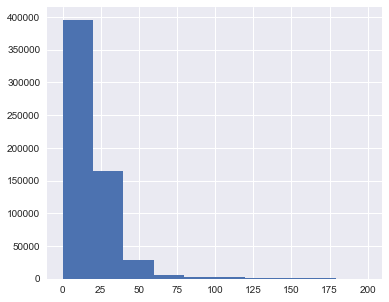

In [18]:
df.loc[df.real_wage < 200,'real_wage'].hist()

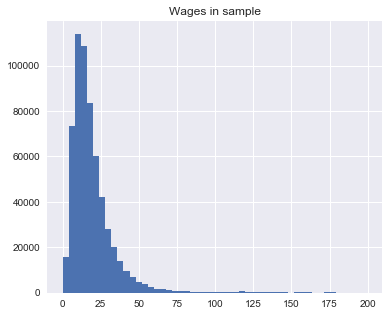

In [19]:
df.loc[df.real_wage < 200,'real_wage'].hist(bins=50)
plt.title('Wages in sample');

### Q10. Drop all rows that have wages above the 99th percentile and below the 1st percentile.

For example, use the code `q01 = df.real_wage.quantile(q=0.01)` to compute the 1st percentile. Then use `df = df[YOUR_MASK_HERE]` or use `df = df.query(YOUR_CODE_HERE)`.

In [20]:
q99 = df.real_wage.quantile(q=0.99)
q01 = df.real_wage.quantile(q=0.01)
df = df.query('@q01 < real_wage < @q99')

In [21]:
q99

117.3219375

In [22]:
q01

2.3011967907208426

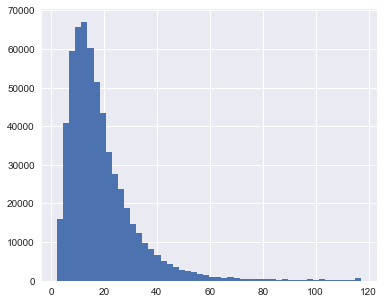

In [23]:
df.real_wage.hist(bins=50)

## Create New Time Series Data

### Q11. Create time series for wages and employment

These first series that we create will not be demographically adjusted. Create these series with the following variable names: `median_wages`, `ave_wages`, and `employment`. Each of these should be computed using the survey weights. Notice that `np.average` has a keyword argument for weights. To construct a weighted median, we will use the `weightedstats` package.

Here is the code to compute the weighted median. Fill in the rest of the code for the other variables.

```python
col = 'real_wage'
weights='ASECWT'

median_wages = (
    df
    .dropna(subset=[col], how='any')
    .groupby('YEAR')
    .apply(lambda row: weightedstats.weighted_median(row[col], weights=row[weights]))
    # Shift time back since the series represents wages from the previous year
    .tshift(-1) 
)
```

NOTE: Wage data needs to be shifted backwards, but employment data does not need to be.

In [24]:
col = 'real_wage'
weights='ASECWT'

median_wages = (
    df
    .dropna(subset=[col], how='any')
    .groupby('YEAR')
    .apply(lambda row: weightedstats.weighted_median(row[col], weights=row[weights]))
    # Shift time back since the series represents wages from the previous year
    .tshift(-1) 
)
ave_wages = (
    df
    .dropna(subset=[col], how='any')
    .groupby('YEAR')
    .apply(lambda row: np.average(row[col], weights=row[weights]))
    .tshift(-1)
)

col = 'in_labor_force'
employment = (
    df
    .dropna(subset=[col], how='any')
    .groupby('YEAR')
    .apply(lambda row: np.average(row[col], weights=row[weights]))
)



### Q12. Concatenate these time series variables together.

Use `pd.concat` to create a new DataFrame called `tdf` that contains `median_wages`, `ave_wages`, and `employment`. Make sure that the column names are preserved in `tdf`.

Running `tdf.head()` should produce the following result at this point.

![`tdf.head()`](./time_series.png)

In [25]:
tdf = pd.concat({
    'ave_wages': ave_wages,
    'median_wages':  median_wages,
    'employment': employment},
    axis=1)
tdf = tdf[['ave_wages', 'median_wages', 'employment']]

In [26]:
tdf.head()

,ave_wages,median_wages,employment
YEAR,,,
1999-01-01,19.378,15.865,nan
2000-01-01,18.954,15.807,0.977
2001-01-01,19.554,15.834,0.976
2002-01-01,19.189,15.582,0.976
2003-01-01,18.929,15.663,0.974


### Q13. Plot the series

Plot `ave_wages` and `median_wages` on the same plot. Make another plot for `employment`.

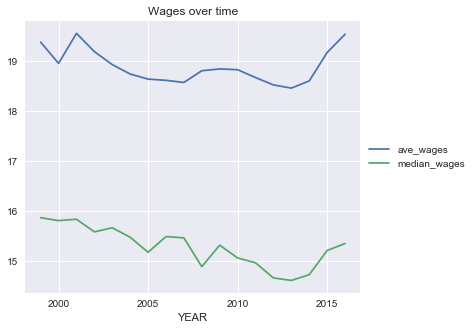

In [27]:
tdf[['ave_wages', 'median_wages']].plot(title='Wages over time')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

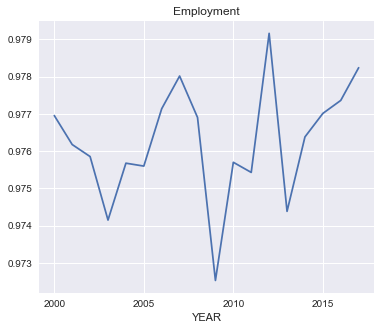

In [28]:
employment.plot(title='Employment')

### Q14. Compute the autocorrelation of each variables in `tdf`

HINT: You can compute the autocorrelation of a single series using, e.g., `tdf.ave_wages.autocorr()`. You can do this for each series in `tdf` in one go by using `tdf.apply(lambda x: YOUR_CODE_HERE)`.

In [29]:
#autocorrelation
tdf.apply(lambda x: x.autocorr())

ave_wages       0.585
median_wages    0.760
employment     -0.009
dtype: float64

### Q15. Compute the contemporeneous correlation between the variables in `tdf`.

This amounts to simply calculating the correlation matrix.

In [30]:
tdf.corr()

,ave_wages,median_wages,employment
ave_wages,1.000,0.636,0.018
median_wages,0.636,1.000,-0.083
employment,0.018,-0.083,1.000


### Q16. Plot median wages and employment on the same graph

Use the following starter code to plot these two series on the same graph, with separate y-axes (a left y-axis and a right y-axis).

```python
ax = YOUR_CODE_HERE.plot(legend=False, color='red')
ax.grid(False)
ax.set_ylabel('Median Wages')
ax2 = ax.twinx()
ax2.grid(False)
ax2.set_ylabel('Employment')
tdf.employment.plot(ax=ax2)
ax.figure.legend()
```

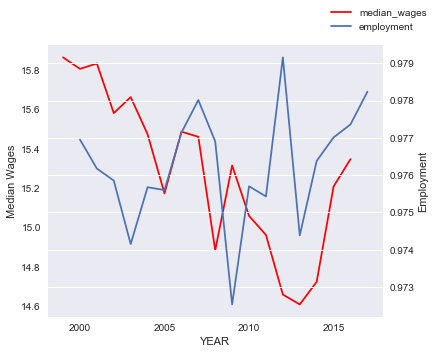

In [31]:
ax = tdf[['median_wages']].plot(legend=False, color='red', label='Wght. Median Wages')
ax.grid(False)
ax.set_ylabel('Median Wages')
ax2 = ax.twinx()
ax2.grid(False)
ax2.set_ylabel('Employment')
tdf.employment.plot(ax=ax2)
ax.figure.legend()

### Q17. Plot median wages growth and employment growth on the same graph

Use the same code as from before. However, apply the method `pct_change()` to the data before plotting it. This will compute the percent changes in each variable over time. Be sure to update the label on the axes.



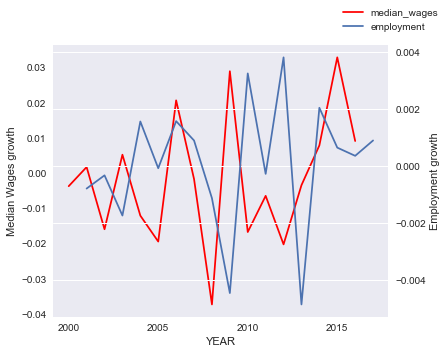

In [32]:
ax = tdf[['median_wages']].pct_change().plot(legend=False, color='red')
ax.grid(False)
ax.set_ylabel('Median Wages growth')
ax2 = ax.twinx()
ax2.grid(False)
ax2.set_ylabel('Employment growth')
tdf.employment.pct_change().plot(ax=ax2)
ax.figure.legend();

### Q18. Plot median wages growth, lagged, and employment growth on the same graph

Use the same code as from before. However, apply the method `tshift(1)` to the wage data before plotting it. This will lag the wage data by one year. Be sure to update the labels of the axes so that we know what we're looking at.

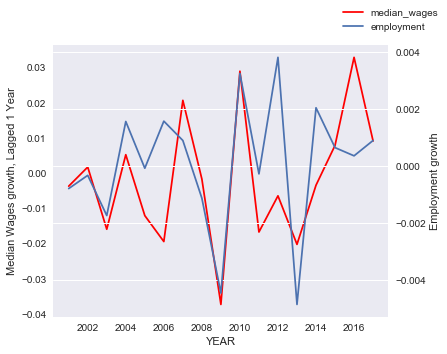

In [33]:
ax = tdf.tshift(1)[['median_wages']].pct_change().plot(legend=False, color='red')
ax.grid(False)
ax.set_ylabel('Median Wages growth, Lagged 1 Year')
ax2 = ax.twinx()
ax2.grid(False)
ax2.set_ylabel('Employment growth')
tdf.employment.pct_change().plot(ax=ax2)
ax.figure.legend()

### Q19. Use the code below as well as the graphs from before to describe what we're seeing in the data.

```python
wages = tdf[['ave_wages', 'median_wages']]
a = pd.concat([wages.pct_change().corrwith(employment.pct_change()),
               wages.pct_change().tshift(1).corrwith(employment.pct_change())],
               axis=1)
a.columns = ['contemporaneous', 'lagged_wage_growth']
print('Correlation of wage growth with employment')
print('Correlation of lagged wage growth with employment')
a
```

In [34]:
# Median wages seems to be positively correlated with 
# lagged wage growth, but negatively correlated with 
# contemporaneous wage growth.

wages = tdf[['ave_wages', 'median_wages']]
a = pd.concat([wages.pct_change().corrwith(employment.pct_change()),
               wages.pct_change().tshift(1).corrwith(employment.pct_change())],
               axis=1)
a.columns = ['contemporaneous', 'lagged_wage_growth']
print('Correlation of wage growth with employment')
print('Correlation of lagged wage growth with employment')
a

Correlation of wage growth with employment
Correlation of lagged wage growth with employment


,contemporaneous,lagged_wage_growth
ave_wages,-0.018,-0.011
median_wages,-0.223,0.574


# Create Demographically Adjusted Series

Here we will demographically adjust the data to adjust for composition changes over time (based on observables).  As employment rates fell, they fell more for low educated workers than high educated workers.  That means the average wages you measured previously will actually be comparing different types of workers in 2010 relative to 2006. To demographically adjust the data, create age-skill groups in each year. Use 5 year age ranges (25-29, 30-34, etc.) and 5 education groupings (less than high school, high school only, some college, bachelor’s degree, more than a bachelor’s degree). Compute wages within these cells for each year (again weighting the data using survey weights). However, when computing time series trends, we will fix the population weights for each cell at year 2000 levels (i.e., the share of the population that lives in each group). So, for each year, you will compute a measure of wages by multiplying the means within each cell during that year by the 2000 shares of population in each cell (and then sum across cells within the year). By doing this, you will be able to compute a demographically adjusted wage series during the 2000 – 2016 period (we have data up to 2017, but the wage variables refer to the wages earned in the previous year). We will discuss how these demographically adjusted wage series compare to your series from before.

### Q20. Create new variables in `df` for age and education bins.

To demographically adjust the data, create age-skill groups in each year. Use 5 year age ranges (25-29, 30-34, etc.) and 5 education groupings (less than high school, high school only, some college, bachelor’s degree, more than a bachelor’s degree).

I have provided starter code here:

```python
# Add bins to `df` for the AGE and EDUC variables as described in
# Question 1.B of the HW.
bins = [25, ... YOUR_CODE_HERE ... , 55]
df['age_binned'] = pd.cut(df.AGE, bins=bins, include_lowest=True, right=False)

educ_bins = [0, 72, 73, YOUR_CODE_HERE , 900]
educ_bin_labels = ['Some_High_School', 'High_School_Diploma', 'Some_College',
                   'Bachelors_Degree', 'Beyond_Bachelors']
df['educ_binned'] = pd.cut(df.EDUC, bins=educ_bins, labels=YOUR_CODE_HERE, include_lowest=True)
```

In [35]:
# Add bins to `df` for the AGE and EDUC variables as described in
# Question 1.B of the HW.
bins = [25, 30, 35, 40, 45, 50, 55]
df['age_binned'] = pd.cut(df.AGE, bins=bins, include_lowest=True, right=False)

educ_bins = [0, 72, 73, 110, 111, 900]
educ_bin_labels = ['Some_High_School', 'High_School_Diploma', 'Some_College',
                   'Bachelors_Degree', 'Beyond_Bachelors']
df['educ_binned'] = pd.cut(df.EDUC, bins=educ_bins, labels=educ_bin_labels, include_lowest=True)

### Q21. Compute the average wages within each education and age group as defined above.

Within in "cell", compute the average wage. You will need to use the survey weights to compute each mean within each cell. The result will be average real wages (deflated with CPI 99) computed over the cross-section and over time.

To do this, use the following starter code:

```python
# Note that the averages are created using the appropriate weights
group_means = (df.dropna()
               .groupby(YOUR_CODE_HERE)
               .apply(lambda x: np.average(YOUR_CODE_HERE))
              )
group_means.name = 'average_wage'
```
For a nicer display at the end, run a code cell with the code `pd.DataFrame(group_means)`.

In [36]:
# Note that the averages are created using the appropriate weights
group_means = (df.dropna().
               groupby(by=['age_binned', 'educ_binned']).
               apply(lambda x: np.average(x.real_wage, weights=x.ASECWT))
              )
group_means.name = 'average_wage'
pd.DataFrame(group_means)

average_wage
age_binned educ_binned                      
[25, 30)   Some_High_School            9.638
           High_School_Diploma        11.992
           Some_College               13.526
           Bachelors_Degree           17.774
           Beyond_Bachelors           20.792
[30, 35)   Some_High_School           10.421
           High_School_Diploma        13.472
           Some_College               15.804
           Bachelors_Degree           21.609
           Beyond_Bachelors           25.710
[35, 40)   Some_High_School           10.949
           High_School_Diploma        14.828
           Some_College               17.829
           Bachelors_Degree           25.322
           Beyond_Bachelors           31.207
[40, 45)   Some_High_School           11.597
           High_School_Diploma        15.573
           Some_College               18.692
           Bachelors_Degree           26.638
           Beyond_Bachelors           33.392
[45, 50)   Some_High_School           11.883
           High_School_Diploma        15.981
           Some_College               19.502
           Bachelors_Degree           27.569
           Beyond_Bachelors           34.029
[50, 55)   Some_High_School           12.251
           High_School_Diploma        16.546
           Some_College               19.843
           Bachelors_Degree           27.206
           Beyond_Bachelors           34.440

### Q22. Display average wages within each education and age group as a table.

Use the `group_means` variable from before. Use `unstack`. Be sure to rearrange to columns so that the education levels appear in the correct order, from lowest educated to highest.

The end results should look like this:

![Means within each group](./table_groups.png)

In [37]:
a = group_means.unstack()
cols = ['Some_High_School', 'High_School_Diploma', 'Some_College', 'Bachelors_Degree', 'Beyond_Bachelors']
# I am doing this to reorder the columns in the way that I want.
a = a[cols]
a

educ_binned,Some_High_School,High_School_Diploma,Some_College,Bachelors_Degree,Beyond_Bachelors
age_binned,,,,,
"[25, 30)",9.638,11.992,13.526,17.774,20.792
"[30, 35)",10.421,13.472,15.804,21.609,25.710
"[35, 40)",10.949,14.828,17.829,25.322,31.207
"[40, 45)",11.597,15.573,18.692,26.638,33.392
"[45, 50)",11.883,15.981,19.502,27.569,34.029
"[50, 55)",12.251,16.546,19.843,27.206,34.440


### Q23. Plot the previous table as a heatmat.

Use seaborn's `heatmap` function. Just input the table from before into `sns.heatmap`. Be sure to use `plt.title` to give the plot an appropriate title.

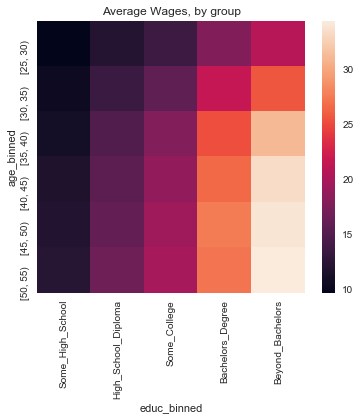

In [38]:
sns.heatmap(a)
plt.title('Average Wages, by group');

### Q24. Create the demographically adjusted series

Now we will compute average and median real wages, grouped by year, age bin, and education level. These `inner_means` will be weighted using survey weights. We will then use summed survey weights from the age and education groups, frozen at year 2000, to compute an adjusted time series for average wages and median wages for the rest of the years.

Use the following started code to complete this:

```python
inner_means = (df
               .groupby(by=['YEAR', 'age_binned', YOUR_CODE_HERE'])
               .apply(lambda x: np.average(YOUR_CODE_HERE, weights=x.ASECWT))
              )
weights_2000 = (df[df.YEAR == YOUR_CODE_HERE]
                .groupby(by=['age_binned', 'educ_binned'])
                .ASECWT
                .sum()
               )

adj_series = (inner_means
              .groupby(level='YEAR')
              .apply(lambda x: np.average(x, weights=weights_2000)))

# Lag, since the we use "last years weeks worked", etc.
adj_series = adj_series.tshift(-1)

tdf['adj_ave_wages'] = adj_series

adj_series = (inner_means
              .groupby(level='YEAR')
              .apply(lambda x: 
                weightedstats.weighted_median(x, weights=weights_2000))
             )
# Lag, since the we use "last years weeks worked", etc.
adj_series = adj_series.tshift(-1)
tdf['adj_median_wages'] = adj_series
```

In [39]:
shift = -1
inner_means = (df
               .groupby(by=['YEAR', 'age_binned', 'educ_binned'])
               .apply(lambda x: np.average(x['real_wage'], weights=x.ASECWT))
              )


# Create Bin Weight Sums
weights_2000 = (df[df.YEAR == '2000']
                .dropna()
                .groupby(by=['age_binned', 'educ_binned'])
                .ASECWT
                .sum()
               )

adj_series = (inner_means
              .groupby(level='YEAR')
              .apply(lambda x: np.average(x, weights=weights_2000)))
# Lag, since the we use "last years weeks worked", etc.
adj_series = adj_series.tshift(shift)
tdf['adj_ave_wages'] = adj_series




In [40]:
# Take Medians within Cells and then average the medians
# This doesn't work too well. Adjusted series is uniformly higher
inner_medians = (df
               .groupby(by=['YEAR', 'age_binned', 'educ_binned'])
               .apply(lambda x: weightedstats.weighted_median(x.real_wage, weights=x.ASECWT))
              )

adj_series = (inner_medians
              .groupby(level='YEAR')
              .apply(lambda x: np.average(x, weights=weights_2000)))
# Lag, since the we use "last years weeks worked", etc.
adj_series = adj_series.tshift(shift)
tdf['adj3_median_wages'] = adj_series

In [41]:
# Sum weights within cell. Force all individuals in that cell to have
# the same weight---their weight is proportional to the cell weight
# Fix these cell weights and apply them to each cell in each year forward
# This works decently well. But, the year 2000 median is not the same
# as the year 200 adjusted median.

# Create new Weights column using the year 2000 weights
def new_weights(x):
    w = x.loc[x.YEAR == '2000', 'ASECWT'].sum()
    x['w2000'] = w
    return x
    
df = df.groupby(by=['age_binned', 'educ_binned']).apply(new_weights)
df['w2000'] = df.groupby('YEAR').w2000.transform(lambda x: x/x.sum())

adj_series = (df
              .groupby('YEAR')
              .apply(lambda x: 
                np.average(x.real_wage, weights=x.w2000))
             )
# Lag, since the we use "last years weeks worked", etc.
adj_series = adj_series.tshift(shift)
tdf['adj2_ave_wages'] = adj_series

adj_series = (df
              .groupby('YEAR')
              .apply(lambda x: 
                weightedstats.weighted_median(x.real_wage, weights=x.w2000))
             )
# Lag, since the we use "last years weeks worked", etc.
adj_series = adj_series.tshift(shift)
tdf['adj_median_wages'] = adj_series

### Q25. Explain my usage of `groupby` above.

Explain the following. Why did I use `groupby(by=[])` in one place and `groupby(level=...)` in another place? Explain the difference between the `by` keyword and the `level` keyword in the `groupby` function. (HINT: Check the documentation and run the code line by line if it's unclear.)

In [42]:
# The difference is that one groups by columns and the other groups by a level in a multi-index.

### Q26. Plot the unadjusted and the demographically adjusted series for average wages on the same plot.

Also, explain what you see.

ANSWER:

In the plot immediately below, we see that the demographically adjusted wage series (`adj_ave_age`) coincides with the unadjusted series in the year 1999 (data from 2000). They diverge as time goes on. This is as expected, and serves as a check that we have performed our calculations correctly. The adjusted wage series is lower than the unadjusted. This suggests that the composition of the labor force was tilting towards higher earning demographics.

Text(0.5,1,'Demographically Adjusted Average Wages')

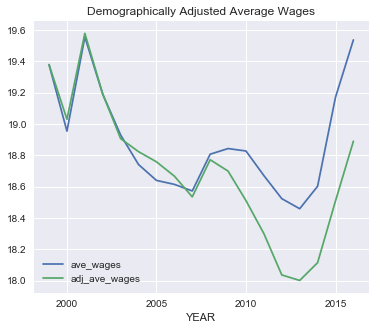

In [43]:
# In the plot immediately below, we see that the demographically 
# adjusted wage series (`adj_ave_age`) coincides with the unadjusted 
# series in the year 1999 (data from 2000). 
# They diverge as time goes on. This is as expected, and serves as a 
# check that we have performed our calculations correctly. 
# The adjusted wage series is lower than the unadjusted. 
# This suggests that the composition of the labor force was tilting 
# towards higher earning demographics.
tdf[['ave_wages', 'adj_ave_wages']].plot()
plt.title("Demographically Adjusted Average Wages")

Text(0.5,1,'Demographically Adjusted Average Wages')

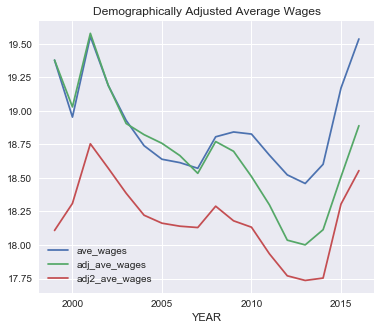

In [44]:
# Test above
tdf[['ave_wages', 'adj_ave_wages', 'adj2_ave_wages']].plot()
plt.title("Demographically Adjusted Average Wages")

### Q26. Plot the unadjusted and the demographically adjusted series for median wages on the same plot.

I'm a little unsure how to explain the changes with respect to adjusted median wages. I will continue to think about it. Feel free to add any suggestions. However, feel free to just plot the graph for this question.

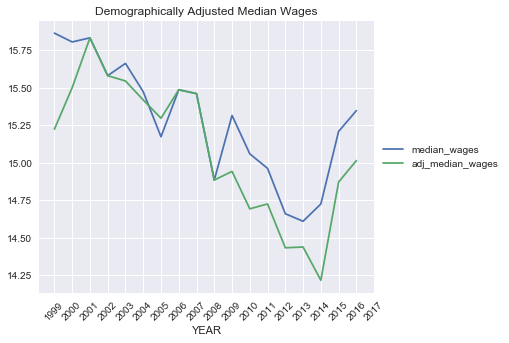

In [45]:
ax = tdf[['median_wages', 'adj_median_wages']].plot()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("Demographically Adjusted Median Wages");
dates = pd.date_range('1999', '2017', freq='YS')
plt.xticks(dates, dates.year)
ax.xaxis.set_tick_params(rotation=45)

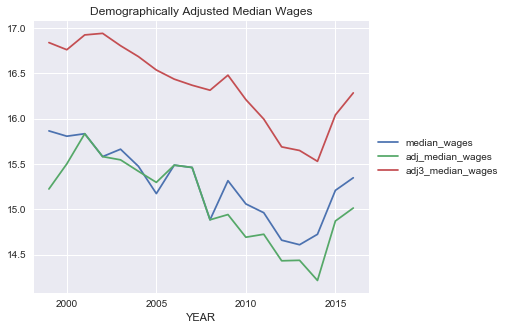

In [46]:
# test above
tdf[['median_wages', 'adj_median_wages', 'adj3_median_wages']].plot()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("Demographically Adjusted Median Wages");

### Q27. Repeat the calculations from Q19, except include the new adjusted series as well. 

What do you see? Is it still puzzling? (NOTE: This is mostly an open-ended question.)

ANSWER:

Now, if we repeat our calculations with regards to the time series correlation between wage growth and employment, we see that the demographically adjusted series moves more with employment. The contemporanous correlation is more negative and the lagged correlation is more positive. This is also a little puzzling.

In [47]:
wages = tdf[['ave_wages', 'median_wages', 'adj_ave_wages', 'adj_median_wages']]
a = pd.concat([wages.diff().corrwith(employment),
               wages.diff().tshift(1).corrwith(employment)],
               axis=1)
a.columns = ['contemporaneous', 'lagged_wage_growth']
print('Correlation of wage growth with employment')
print('Correlation of lagged wage growth with employment')
a

Correlation of wage growth with employment
Correlation of lagged wage growth with employment


,contemporaneous,lagged_wage_growth
ave_wages,0.158,0.141
median_wages,-0.238,0.574
adj_ave_wages,0.136,0.139
adj_median_wages,-0.016,0.606


### Q28. Approximately how long did it take to complete this assignment? (e.g. 4.5 hours)

# Conclusion

Note that there is more that we could do with this. For one, we could try to account for changes in employment. For example, the procedure would work like this:

> We could impute wages for those not working.  So your sample will now expand to all workers – even those without a measured wage.   We can do the imputation in a crude way. Using this new sample, define demographic groups by age-skill for each year. For each person without out a wage in a given year – match them to their demographic cell in that year.  For your imputation, assign those with a missing wage in that year to the 33rd percentile of the wages within that cell (for that year).   Note – those with the highest wages will be at the 99th percentile.  This assumes that those with a missing wage (of a given age-skill type) are disproportionately drawn from the bottom part of their age-skill wage distribution.   Still adjust the wages for changing demographic composition by fixing the weights for each demographic cell at their 2000 level (using the full sample including the zeros).  

We could then ask ,how do the time series patterns in these demographically adjusted wages (including the zeros) compare to the wage series created previously?  How would things change if you used the 50th percentile to conduct the imputation?

In addition, we could also repeat this exercise using data from the 2000 Census and the 2001-2014 American Community Survey (downloaded from the IPUMS USA website---a different data set from the IPUMS CPS data set that we used here).

All of these things could help us to better understand this puzzling fact that we see in the data.

### For fun, I provide code to compute the imputed wages described above.

This is not part of the assignment. Also, I do not guarantee that it is working yet. However, feel free to experiment with it if you want.

In [48]:
def create_demographically_adjusted_series(df, column_to_adjust="real_wage", shift=-1, drop=True):
    """Create Demographically Adjusted Series"""
    
    inner_means = df.groupby(by=['YEAR', 'age_binned', 'educ_binned'])\
        .apply(lambda x: np.average(x[column_to_adjust], weights=x.ASECWT))
    weights_2000 = df[df.YEAR == '2000'].dropna().groupby(by=['age_binned', 'educ_binned'])\
        .ASECWT.sum()

    adj_series = inner_means.groupby(level='YEAR').apply(lambda x: np.average(x, weights=weights_2000))
    # Lag, since the we use "last years weeks worked", etc.

    adj_series = adj_series.tshift(shift)
    adj_series.name = "Dem. Adj. " + column_to_adjust
    return adj_series

def create_imputed_wages(df, quantile=.33):
    """Calculate quantile and impute wages"""
    groups = ['YEAR', 'age_binned', 'educ_binned']
    wage_quantiles = df.dropna().groupby(groups).real_wage.quantile(q=quantile)
    fill_func = lambda g: g.fillna(wage_quantiles[g.name])
    return df.groupby(groups).real_wage.apply(fill_func)

In [49]:
df['imputed_wage_33'] = create_imputed_wages(df, quantile=.33)
wages['adj_imputed_wage_33'] = create_demographically_adjusted_series(df,\
    column_to_adjust='imputed_wage_33', drop=False)

C:\Users\Jeremy\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [50]:
df['imputed_wage_50'] = create_imputed_wages(df, quantile=.50)
wages['adj_imputed_wage_50'] = create_demographically_adjusted_series(df,\
    column_to_adjust='imputed_wage_50', drop=False)

C:\Users\Jeremy\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In the plot below, we see that including the imputed wages lowers the wages. However, the time series properties appear to be quite similar.

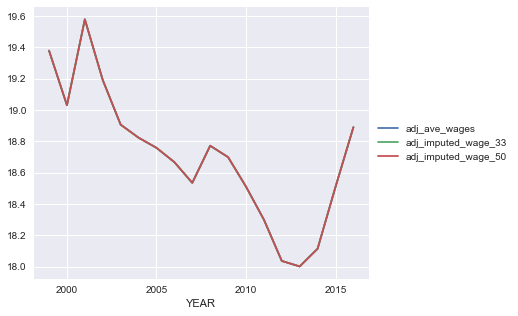

In [51]:
wages[['adj_ave_wages', 'adj_imputed_wage_33', 'adj_imputed_wage_50']].plot()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

Furthermore, we see that the correlations of wage growth are not changed very much either.

In [52]:
a = pd.concat([wages.diff().corrwith(employment),
               wages.diff().tshift(1).corrwith(employment)],
               axis=1)
a.columns = ['contemporaneous', 'lagged_wage_growth']
print('Correlation of wage growth with employment')
print('Correlation of lagged wage growth with employment')
a

Correlation of wage growth with employment
Correlation of lagged wage growth with employment


,contemporaneous,lagged_wage_growth
ave_wages,0.158,0.141
median_wages,-0.238,0.574
adj_ave_wages,0.136,0.139
adj_median_wages,-0.016,0.606
adj_imputed_wage_33,0.136,0.139
adj_imputed_wage_50,0.136,0.139
